In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os, re
from utility_functions import *
from matplotlib_venn import venn2, venn3
sns.set_context('paper')

In [22]:
working_folder = "C:/Users/Enrico/OneDrive - UGent/run-ionbot"
PXDs = [
    "PXD002057.v0.11.4", 
    "PXD005833.v0.11.4",
    "PXD014258.v0.11.4",
]
filtering_methods = [
    False, 'global', 'groupwalk', 'custom', 'hybrid'
]
FILT_ORDER = ['Unfiltered','Global','GroupWalk','Custom','Hybrid']

In [9]:
def compare_filtering_IDrates(working_folder_, dataset_name_):
    unfiltered         = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-False.csv"))
    global_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-global.csv"))
    groupwalk_filtered = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-groupwalk.csv"))
    custom_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-custom.csv"))
    hybrid_filtered    = pd.read_csv(os.path.join(working_folder_, dataset_name_, "ID-rate-df-filt-hybrid.csv"))
    
    unfiltered['Filter'] = 'Unfiltered'
    global_filtered['Filter'] = 'Global'
    groupwalk_filtered['Filter'] = 'GroupWalk'
    custom_filtered['Filter'] = 'Custom'
    hybrid_filtered['Filter'] = 'Hybrid'
    
    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered, hybrid_filtered], ignore_index=True)
    data['PXD'] = dataset_name_
    return data

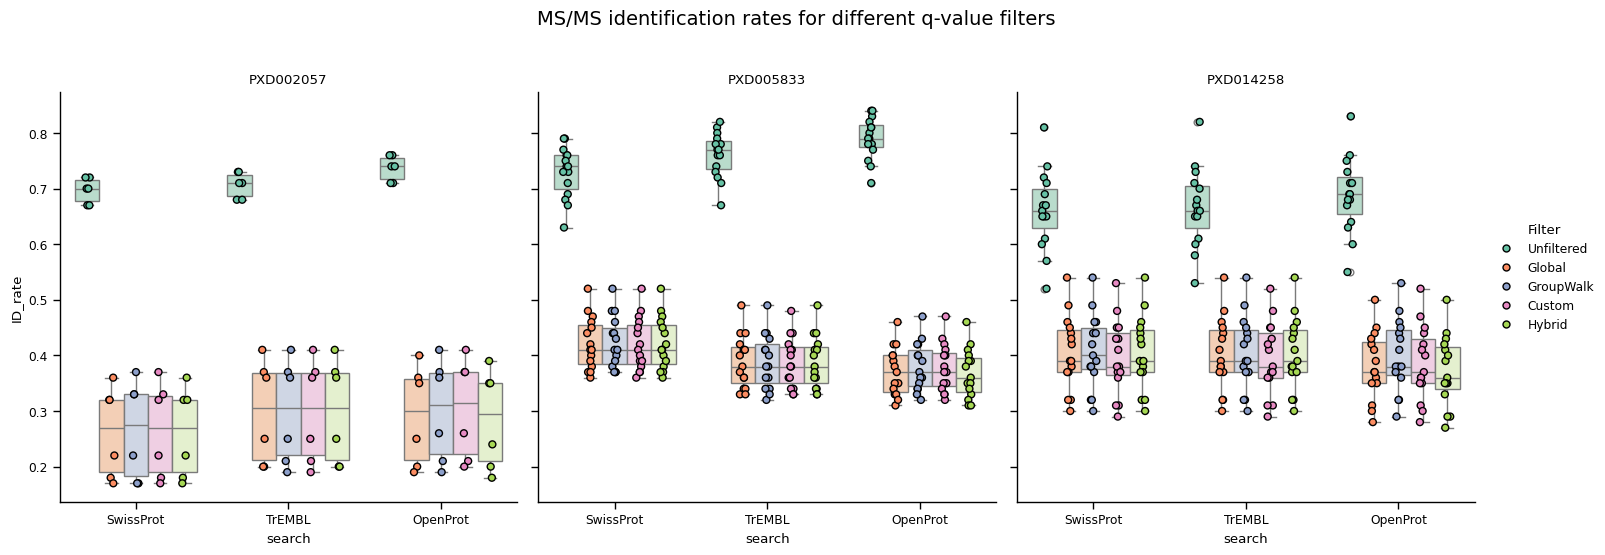

In [10]:
tmp = [compare_filtering_IDrates(working_folder, dataset_name) for dataset_name in PXDs]
tmp = pd.concat(tmp, ignore_index=True)
G = sns.catplot(data=tmp, x='search', y='ID_rate', hue='Filter', dodge=True, edgecolor='k', linewidth=1, hue_order=FILT_ORDER, col='PXD',
               palette='Set2')
G.fig.suptitle(f"MS/MS identification rates for different q-value filters", size=14, y=1.1)
for ax in G.axes[0]:
    t = ax.title.get_text()
    t = t.split()[2]
    sns.boxplot(data=tmp[tmp.PXD==t], x='search', y='ID_rate', hue='Filter', 
                dodge=True, palette='Pastel2', legend=False, hue_order=FILT_ORDER, ax=ax)
    t = t.split('.')[0]
    ax.set_title(t)
plt.savefig('./publication-data/ID-rates-1.svg', dpi=300, bbox_inches='tight')

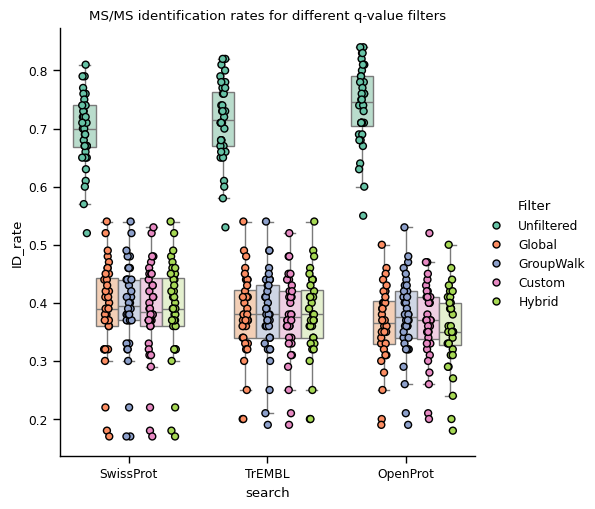

In [13]:
tmp = [compare_filtering_IDrates(working_folder, dataset_name) for dataset_name in PXDs]
tmp = pd.concat(tmp, ignore_index=True)

sns.catplot(data=tmp, x='search', y='ID_rate', hue='Filter', dodge=True, edgecolor='k', 
            linewidth=1, hue_order=FILT_ORDER, 
            palette='Set2')
sns.boxplot(data=tmp, x='search', y='ID_rate', hue='Filter', 
            dodge=True, palette='Pastel2', legend=False, showfliers=False, hue_order=FILT_ORDER)
plt.title(f"MS/MS identification rates for different q-value filters")
plt.savefig('./publication-data/ID-rates-2.svg', dpi=300, bbox_inches='tight')

-----

In [16]:
SEARCHES = ['openprot']
DATASETS = pd.MultiIndex.from_product([PXDs,SEARCHES])
DATASETS

folders = {dataset_name:{search:[] for search in SEARCHES} for dataset_name in PXDs}
for dataset_name in PXDs:
    for search in SEARCHES:   
        for fld in os.scandir(os.path.join(working_folder, dataset_name, f"{dataset_name}-{search}")):
            if not fld.name.startswith('.') and os.path.isdir(fld.path): 
                folders[dataset_name][search].append(fld)
folders

{'PXD002057.v0.11.4': {'openprot': [<DirEntry '130327_o2_01_hu_C1_2hr-openprot'>,
   <DirEntry '130327_o2_02_hu_P1_2hr-openprot'>,
   <DirEntry '130327_o2_03_hu_C2_2hr-openprot'>,
   <DirEntry '130327_o2_04_hu_P2_2hr-openprot'>,
   <DirEntry '130327_o2_05_hu_C3_2hr-openprot'>,
   <DirEntry '130327_o2_06_hu_P3_2hr-openprot'>]},
 'PXD005833.v0.11.4': {'openprot': [<DirEntry 'AM10-openprot'>,
   <DirEntry 'AM11-openprot'>,
   <DirEntry 'AM12-openprot'>,
   <DirEntry 'AM13-openprot'>,
   <DirEntry 'AM14-openprot'>,
   <DirEntry 'AM15-openprot'>,
   <DirEntry 'AM16-openprot'>,
   <DirEntry 'AM17-openprot'>,
   <DirEntry 'AM18-openprot'>,
   <DirEntry 'AM19-openprot'>,
   <DirEntry 'AM20-openprot'>,
   <DirEntry 'AM21-openprot'>,
   <DirEntry 'AM7-openprot'>,
   <DirEntry 'AM8-openprot'>,
   <DirEntry 'AM9-openprot'>]},
 'PXD014258.v0.11.4': {'openprot': [<DirEntry 'ESC-HF-Sample-BT474-openprot'>,
   <DirEntry 'ESC-HF-Sample-MCF-openprot'>,
   <DirEntry 'ESC-HF-SampleHela-openprot'>]}}

In [29]:
for dataset_name in PXDs:
    for search in SEARCHES: 
        tmp = []
        for filtering,label in zip(filtering_methods,FILT_ORDER):
            for fld in folders[dataset_name][search]:
                # print((fld,filtering))
                tmp2 = get_FDR_df(os.path.join(fld.path,"group-walk-output.csv"), filtering)
                tmp2['filtering'] = label
                # print(tmp2)
                tmp.append(tmp2)
tmp = pd.concat(tmp, ignore_index=True)
tmp

,isCanonical,isModified,FDR,filtering
0,Canonical,Expected,0.363447,Unfiltered
1,Canonical,Unexpected,0.199409,Unfiltered
2,Canonical,Unmodified,0.038490,Unfiltered
3,NonCanonical,Expected,0.857929,Unfiltered
4,NonCanonical,Unexpected,0.753260,Unfiltered
...,...,...,...,...
85,Canonical,Unexpected,0.015511,Hybrid
86,Canonical,Unmodified,0.002516,Hybrid
87,NonCanonical,Expected,0.000000,Hybrid
88,NonCanonical,Unexpected,0.009615,Hybrid


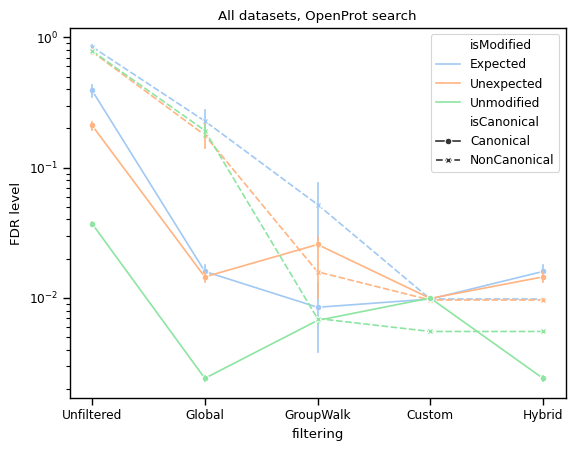

In [43]:
g = sns.lineplot(data=tmp[tmp.FDR>0], y='FDR', x='filtering', style='isCanonical', hue='isModified', 
                      markers=True, palette='pastel', err_style="bars", errorbar=("se", 2),)
# g.axhline(0.01, c='k', ls='-.', lw=.5)
g.set_title(f"All datasets, OpenProt search")
g.set_ylabel('FDR level')
g.set_yscale('log')
plt.savefig('./publication-data/FDR-levels-2se-deviation.svg', dpi=300, bbox_inches='tight')

----
----

In [6]:
def get_FDR_df(PATH, filtering=False):
    df = pd.read_csv(PATH, low_memory=False)
    df.rename(columns={'q.value':'global_q'}, inplace=True)
    
    if filtering=='global':
        df = df[df.global_q<0.01].copy(deep=True)
    elif filtering=='groupwalk':
        df = df[df.group_qval<0.01].copy(deep=True)
    elif filtering=='custom':
        df = df[df.custom_q<0.01].copy(deep=True)
    elif filtering=='hybrid':
        df['hybrid_q'] = df.apply(lambda row: row.custom_q if row.isCanonical=="NonCanonical" else row.global_q, axis=1)
        df = df[df.hybrid_q<0.01].copy(deep=True)
    elif filtering: 
        # gives error if filtering is not False
        print(f'Error! Filtering = {filtering}')
        return filtering

    FDR_df = []
    for (c,m),df in df.groupby(['isCanonical','isModified']).__iter__():
        if c=='Contam':
            continue
        tmp = df.database.value_counts()
        try:
            fdr = tmp['D']/tmp['T']
            # fdr = (2*tmp['D'])/(tmp['D']+tmp['T'])
        except:
            fdr = 0
            tmp['D'] = 0
        FDR_df.append([c,m,fdr])
    return pd.DataFrame(FDR_df, columns=['isCanonical','isModified','FDR'])

# def plot_FDR_levels(working_folder_, dataset_name_):
#     file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name_}-openprot", "combo-group-walk-output.csv")
#     unfiltered         = get_FDR_df(file_path)
#     global_filtered    = get_FDR_df(file_path, filtering='global')
#     groupwalk_filtered = get_FDR_df(file_path, filtering='groupwalk')
#     custom_filtered    = get_FDR_df(file_path, filtering='custom')

#     unfiltered['filter'] = 'Unfiltered'
#     global_filtered['filter'] = 'Global'
#     groupwalk_filtered['filter'] = 'GroupWalk'
#     custom_filtered['filter'] = 'Custom'

#     data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered], ignore_index=True)
    
#     ax = sns.lineplot(data=data, y='FDR', x='filter', style='isCanonical', hue='isModified', 
#                       markers=True, palette='pastel', 
#                       # order=FILT_ORDER
#                      )
#     plt.title(f"{dataset_name.split('.')[0]}, OpenProt search")
#     plt.ylabel('FDR level')
#     plt.yscale('log')
#     plt.ylim(0.001, 1)
#     sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#     plt.show()

def plot_FDR_levels_2(working_folder_, dataset_name_, ax_):
    file_path = os.path.join(working_folder_, dataset_name_, f"{dataset_name_}-openprot", "combined-results-w-qvalues.csv.gz")
    unfiltered         = get_FDR_df(file_path)
    global_filtered    = get_FDR_df(file_path, filtering='global')
    groupwalk_filtered = get_FDR_df(file_path, filtering='groupwalk')
    custom_filtered    = get_FDR_df(file_path, filtering='custom')
    hybrid_filtered    = get_FDR_df(file_path, filtering='hybrid')

    unfiltered['filter'] = 'Unfiltered'
    global_filtered['filter'] = 'Global'
    groupwalk_filtered['filter'] = 'GroupWalk'
    custom_filtered['filter'] = 'Custom'
    hybrid_filtered['filter'] = 'Hybrid'

    data = pd.concat([unfiltered, global_filtered, groupwalk_filtered, custom_filtered, hybrid_filtered], ignore_index=True)
    data = data[data.FDR>0].copy(deep=True)
    
    g = sns.lineplot(data=data, y='FDR', x='filter', style='isCanonical', hue='isModified', 
                      markers=True, palette='pastel', 
                      ax=ax_
                     )
    g.axhline(0.01, c='k', ls='--', lw=.75)
    g.set_title(f"{dataset_name.split('.')[0]}, OpenProt search")
    g.set_ylabel('FDR level')
    g.set_yscale('log')

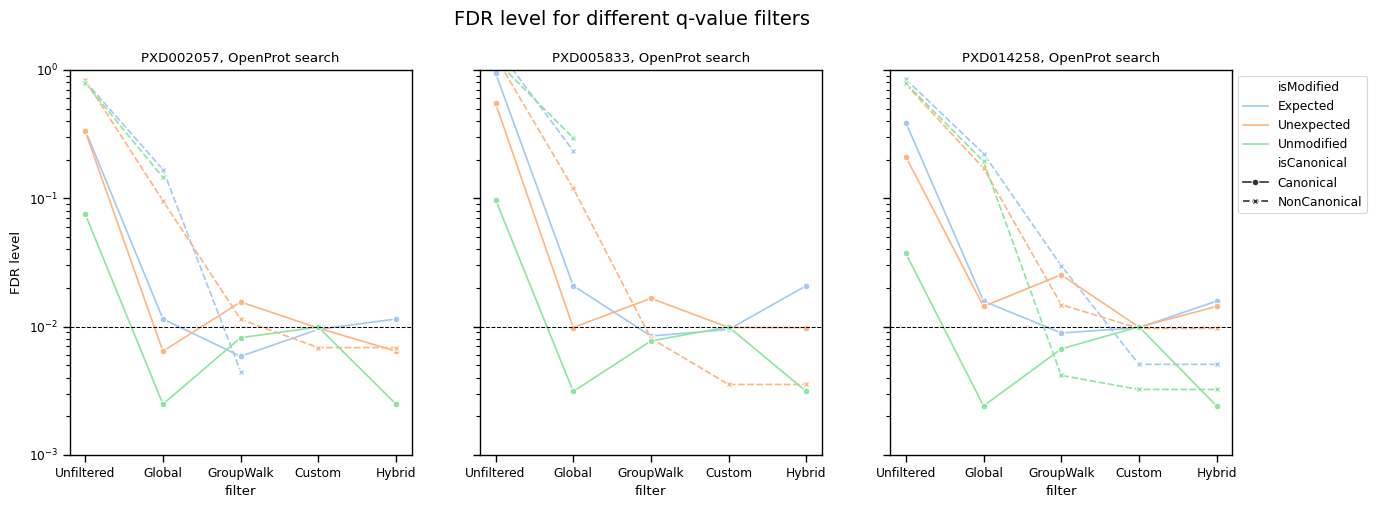

In [10]:
fig,axes = plt.subplots(1,3,sharey=True, figsize=(15,5))
fig.suptitle(f"FDR level for different q-value filters", size=14, y=1)
for dataset_name,ax in zip(PXDs,axes):
    plot_FDR_levels_2(working_folder, dataset_name, ax)
for _ in axes:
    _.set_ylim(0.001, 1)
axes[0].legend_.remove()
axes[1].legend_.remove()
sns.move_legend(axes[2], "upper left", bbox_to_anchor=(1, 1))
# plt.savefig('./publication-data/FDR-levels.svg', dpi=300, bbox_inches='tight')

In [11]:
for dataset_name in PXDs:
    for filtering in filtering_methods:
        print([dataset_name,filtering])
        print(get_FDR_df(os.path.join(working_folder, dataset_name, 
                                      f"{dataset_name}-openprot", 
                                      "combined-results-w-qvalues.csv.gz"),
                         filtering=filtering))
        print('')

['PXD002057.v0.11.4', False]
    isCanonical  isModified       FDR
0     Canonical    Expected  0.340111
1     Canonical  Unexpected  0.332064
2     Canonical  Unmodified  0.075277
3  NonCanonical    Expected  0.815649
4  NonCanonical  Unexpected  0.832305
5  NonCanonical  Unmodified  0.790754

['PXD002057.v0.11.4', 'global']
    isCanonical  isModified       FDR
0     Canonical    Expected  0.011460
1     Canonical  Unexpected  0.006427
2     Canonical  Unmodified  0.002487
3  NonCanonical    Expected  0.167504
4  NonCanonical  Unexpected  0.095668
5  NonCanonical  Unmodified  0.145455

['PXD002057.v0.11.4', 'groupwalk']
    isCanonical  isModified       FDR
0     Canonical    Expected  0.005864
1     Canonical  Unexpected  0.015549
2     Canonical  Unmodified  0.008189
3  NonCanonical    Expected  0.004464
4  NonCanonical  Unexpected  0.011382
5  NonCanonical  Unmodified  0.000000

['PXD002057.v0.11.4', 'custom']
    isCanonical  isModified       FDR
0     Canonical    Expected  0.00

In [12]:
autosave()

True
